STA 220 Homework 2
===========

- Do not distribute
- Do the entire homework here in the notebook by adding cells below the given exercise.
- When turning the homework in simply submit your notebook file to canvas.
- Obviously, do not copy the code from some online source or the other students.
- After finishing the homwork, please select Kernel -> Restart & Run All, then save, submit

The multi-armed bandit framework assumes that you are in a two player game where you select a number from 1 to K (we call this number the arm that you pulled).  Then the other player selects a reward, $r_{i,t}$ based on the arm, $i$, at time $t$ that you selected and reveals that to you.  Your job is to come up with a policy which determines which arm to pull at a given time based on the past performances of the arms.

The name multi-armed bandit comes from the gambling world, in which a slot machine is called a one armed bandit.  In that setting, you pull the arm and recieve some reward.  In this fictional setting there are multiple arms for the slot machine, each paying out different rewards.  Because you can only pull one at a time, you only see the reward from the arm you pulled.  This partial observability puts you in the challenging position of needing to explore the arms, seeing which has better performance, before you start to exploit the best arm.  Below is a simulation from a simple mult-armed bandit.

In [1]:
import numpy as np
import time

In [303]:
class SimpleBandit:
    '''
    The bandit class you will use in this homework. DO NOT modify
    '''
    def __init__(self):
        self._mu = np.array([-1.,-2.,1.5,0.5,-0.25,.75,.1,1.8,-3])
        self._p = 1 / (1 + np.exp(-self._mu))
        self.num_arms = len(self._mu)
        self.total_rewards = np.zeros(len(self._mu))
        
    def pull(self,arms):
        self.current_rewards = np.random.binomial(1,self._p)
        self.total_rewards += self.current_rewards
        return self.current_rewards[arms]

In [304]:
np.random.seed(5)
band = SimpleBandit()
[band.pull(1) for t in range(10)]

10

In the above we see that if we had pulled the 1 arm 10 times then our total reward for that arm is 2 because it returned a 1 twice.  Our rewards are binary, only 0 or 1.  You can also see the total rewards from each arm below.

In [30]:
band.total_rewards

array([2., 2., 9., 6., 2., 6., 3., 8., 0.])

One simple policy is to always pull the arm 2, and another is to pull the arm 1.  We can compare these with the following:

In [305]:
rewards = np.array([band.pull([1,2]) for t in range(100)])

110

rewards now has the rewards for each policy in each column, we can compare the rewards for these policies below.

In [32]:
rewards.sum(axis=0)

array([14, 90])

It seems that 'always pull 2' is a better policy.  Another simple policy is to randomly select an arm and pull it.  This can be seen as a pure exploration policy.  All of your policies should have the select_arm method which tells you which arm to pull, and the update_reward method which updates any internal state information based on the observed reward.  In this case nothing needs to be updated.

In [293]:
class RandomPolicy:
    """
    Random policy, pure exploration. DO NOT modify
    """
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.current_arm = None
        
    def select_arm(self):
        """
        choose which arm to pull
        """
        self.current_arm = np.random.randint(self.num_arms)
        return self.current_arm
    
    def update_reward(self, reward):
        """
        enter observed reward
        """
        return None

**Exercise 1.** The regret of a bandit policy is the difference between the total reward you would get from the "best" arm in hindsight and the total reward your policy recieved.  So if your policy selected arms $i_1,\ldots,i_T$ for total of $T$ time, then the regret is 
$$\max_j \sum_{t=1}^T r_{j,t} - \sum_{t=1}^T r_{i_t,t}.$$
The SimpleBandit class maintains what reward you would have recieved if you just pulled a given arm in the ``total_rewards`` attribute (`current_rewards[i]` is the total reward recieved if i is pulled each time).  Fill the def below which takes a list of policies to play over T time steps and returns a list of regrets for each policy.  Test it on the simple bandit and random policy.

In [306]:
def run_trajectory(bandit, policies, T):
    """
    Run T steps of bandit pulling each policy in each time step
    
    Arguments: 
    bandit: 
        a fresh instance of a Bandit class, 
        in this homework you will be always using an instance from RandomPolicy class
    
    policies:
        a list like [policy1, policy2, policy3 ...]
        each of the policy will have select_arm method and update_reward method
    
    Output: 
        regret of each policy in list, like
        [regret1, regret2, ...]
    """
    bandit_0 = bandit
    for t in range(T):
        bandit_0.pull(1) 
    max_pol = max(bandit_0.total_rewards)
    regret_list=[]
    for policy in policies:
        exact_rewards = []
        for t in range(T):
            current_reward = bandit.pull(policy.select_arm())
            exact_rewards.append(current_reward)
            policy.update_reward(current_reward)
        regret_list.append(max_pol - sum(exact_rewards))
    return regret_list

In [307]:
# test code, do not change
t1 = time.time()
regrets = [run_trajectory(SimpleBandit(), [RandomPolicy(9)], 1000) for _ in range(10)]
print('Time Usage : {}'.format(time.time() - t1))
np.mean(regrets)

Time Usage : 0.3988947868347168


371.1

**Exercise 2.** epsilon-greedy is a policy that has a few roughly equivalent variants, but the one we will use is the following:  For each time step, with probability epsilon, pull an arm at random, otherwise pull the current best arm.  The current best arm is the one which has the most total reward up to that time.  If there is a tie for current best policy, break the tie randomly.

Implement epsilon-greedy in the following class, test it by having it compete once with the random policy for epsilon=0.1 for T = 1000 time points.

In [308]:
# change the class below
class Epsilon_Greedy_Policy:
    
    def __init__(self, num_arms, eps):
        self.num_arms = num_arms
        self.eps = eps
        self.current_arm = None
        self.reward = np.zeros(num_arms)
        self.number = np.zeros(num_arms)
        
    def select_arm(self):
        """
        choose which arm to pull
        use random.choice to choose the arm with max mean 
        """
        if np.random.binomial(1,self.eps) == 1:
            self.current_arm = np.random.randint(self.num_arms)
        else:
            self.current_arm = np.random.choice(list(np.where(np.array(self.reward) == max(self.reward))[0]),1)[0]
        
        self.number[self.current_arm] += 1
        return self.current_arm
    
    def update_reward(self, reward):
        self.reward[self.current_arm] = (self.reward[self.current_arm] * (self.number[self.current_arm] - 1) + reward)/self.number[self.current_arm]

        

    # more methods if you need

In [309]:
# test code
t1 = time.time()
regrets = []

# Your code here, 
    # generate 10 regrets with simple bandit and epsilon-greedy policy, 
    # save results in regrets,
    # refer to second block in exercise 1

    
regrets = [run_trajectory(SimpleBandit(), [Epsilon_Greedy_Policy(9,0.1)], 1000) for _ in range(10)]

print('Time Usage : {}'.format(time.time() - t1))
np.mean(regrets)

Time Usage : 0.5545511245727539


71.3

**Exercise 3.** Exp3 is a policy that is more nuanced.  The idea is that at each time point you pull an arm with some probability `pi[i]` which is updated based on the performance of the arm.  Look at the full algorithm in http://proceedings.mlr.press/v24/seldin12a/seldin12a.pdf, Algorithm 1.  

Implement this version of the Exp3 algorithm in the following class, test it by having it compete once with the random policy for T = 1000 time points.

In [310]:
# change the class below
class Exp3:
    
    def __init__(self, num_arms):
        """
        use self.p to record p_{i,t}
        """
        self.num_arms = num_arms
        self.current_arm = None
        self.p = np.zeros(num_arms)
        self.R = np.zeros(num_arms)
        self.t = 0

        
    def select_arm(self):
        sum_value = 0
        t = self.t
        for j in range(self.num_arms):
            sum_value += np.exp(self.epsilon_t(t) * self.R[j]) 
        for j in range(self.num_arms):
            self.p[j] = (1 - self.num_arms * self.epsilon_t(t+1)) * np.exp(self.epsilon_t(t) * self.R[j]) / sum_value + self.epsilon_t(t+1)
        self.current_arm = np.random.choice(self.num_arms, 1, p = self.p)
        return self.current_arm
                                               
    def epsilon_t(self,a):
        if a == 0:
            ep_1 = 1/self.num_arms
        else:
            ep_1 = min(1/self.num_arms, np.sqrt(np.log(self.num_arms)/(self.num_arms * a)))
        return ep_1
        
                                               
    def update_reward(self, reward):
        self.R[self.current_arm] +=  reward / self.p[self.current_arm]
        self.t += 1
        
    # more methods if you need

In [311]:
# test code
t1 = time.time()
regrets = []

# Your code here, 
    # generate 10 regrets with simple bandit and Exp3 policy, 
    # save results in regrets,
    # refer to second block in exercise 1
regrets = [run_trajectory(SimpleBandit(), [Exp3(9)], 1000) for _ in range(10)]
print('Time Usage : {}'.format(time.time() - t1))
np.mean(regrets)

Time Usage : 1.792206048965454


149.0

**Exercise 4.** The Upper Confidence Bound (UCB) algorithm is intuitive.  You pull the arm that has the largest upper confidence bound for the mean reward.  So if you have an upper bound on the mean reward for an arm this is either because the arm is performing well or you have not pulled the arm much, resulting in a wide confidence interval.  The UCB for arm i is then,
$$ U_{i,t} = \hat \mu_{i,t} + C \sqrt{\frac{\log(t)}{n_{i,t} + 1}}$$
where $\hat \mu_{i,t}$ is the mean reward of the arm up to time $t$, $n_{i,t}$ is the number of times that that arm has been pulled.  $C$ is an argument (can be taken to be 2 by default).

Implement this version of the UCB algorithm in the following class, test it by having it compete once with the random policy for T = 1000 time points with $C = 2$.

In [300]:
# change the class below
class UCB:
    
    def __init__(self, num_arms, C):
        """
        use self.U to record U_{i,t}
        use self.n to record n_{i,t}
        """
        self.num_arms = num_arms
        self.C = C
        self.current_arm = None
        self.U = np.zeros(num_arms)
        self.reward = np.zeros(num_arms)
        self.n = np.zeros(num_arms)
        
    def select_arm(self):
        """
        choose which arm to pull
        use random.choice to choose the arm with max U 
        """
        self.current_arm = np.random.choice(list(np.where(np.array(self.U) == max(self.U))[0]),1)[0]
        return self.current_arm
        
    def update_reward(self, reward):
        self.n[self.current_arm] += 1
        t = sum(self.n)
        self.reward[self.current_arm] = (self.reward[self.current_arm] * (self.n[self.current_arm] - 1) + reward)/self.n[self.current_arm]
        for j in range(self.num_arms):
            self.U[j] = self.reward[j] + self.C * np.sqrt(np.log(t + 1)/(self.n[j] + 1))
        
    # more methods if you need

In [301]:
# test code
t1 = time.time()
regrets = []

# Your code here, 
    # generate 10 regrets with simple bandit and UCB policy, 
    # save results in regrets,
    # refer to second block in exercise 1
regrets = [run_trajectory(SimpleBandit(), [UCB(9, 2)], 1000) for _ in range(10)]
print('Time Usage : {}'.format(time.time() - t1))
np.mean(regrets)

Time Usage : 0.8557462692260742


156.7

**Exercise 5.** 

1. Modify the `run_trajectory` def to output all of the regrets up to that time in a T x K (for K policies) array.
2. Try 4 different values of $\epsilon$ for epsilon-greedy: 0.01, 0.05, 0.1, 0.2 and have them compete.  Plot the regrets as a function of t.  Note the best performing selection of $\epsilon$ at $T = 1000$.
3. Try 4 different values of $C$ in UCB: 0.5, 0.75, 1, 2 and have them compete.  Plot the regrets as a function of t.  Note the best performing selection of $C$ at $T = 1000$.
4. Using the optimal values of $C$ and $\epsilon$ have all four methods compete. Plot the regrets as a function of t, remark on if the relative performance changes over time.  Is one algorithm always dominant?  Make any other conclusions.

**Note**: 
  + Please finishe 4 parts in 4 code blocks.
  + For part 2, 3, and 4 you should call `run_trajectory` in each of them. In the end of each part, you need to write a markdown block to explain your findings and state your conclusion.
  + For each part, set figure size to (17, 8), plot all lines in the same graph and set proper title. DO NOT create more than 1 subplots. Include legend in your plots so that they are easy to read.

In [320]:
# Part 1. Write run_trajectory function here again, do not modify the above block
def run_trajectory_2(bandit, policies, T):
    """
    Run T steps of bandit pulling each policy in each time step
    
    Arguments: 
    bandit: 
        a fresh instance of a Bandit class, 
        in this homework you will be always using an instance from RandomPolicy class
    
    policies:
        a list like [policy1, policy2, policy3 ...]
        each of the policy will have select_arm method and update_reward method
    
    Output: 
        regret of each policy in list, like
        [regret1, regret2, ...]
    """
    regret_all,exact_rewards = [],[]
    bandit_0 = bandit

    for t in range(T):
        bandit_0.pull(1) 
        max_pol = max(bandit_0.total_rewards)
        regret_list = 0
        for policy in policies:
            current_reward = bandit.pull(policy.select_arm())
            exact_rewards.append(current_reward)
            policy.update_reward(current_reward)
        regret_list = max_pol - sum(exact_rewards)
        regret_all.append(regret_list)
    return regret_all

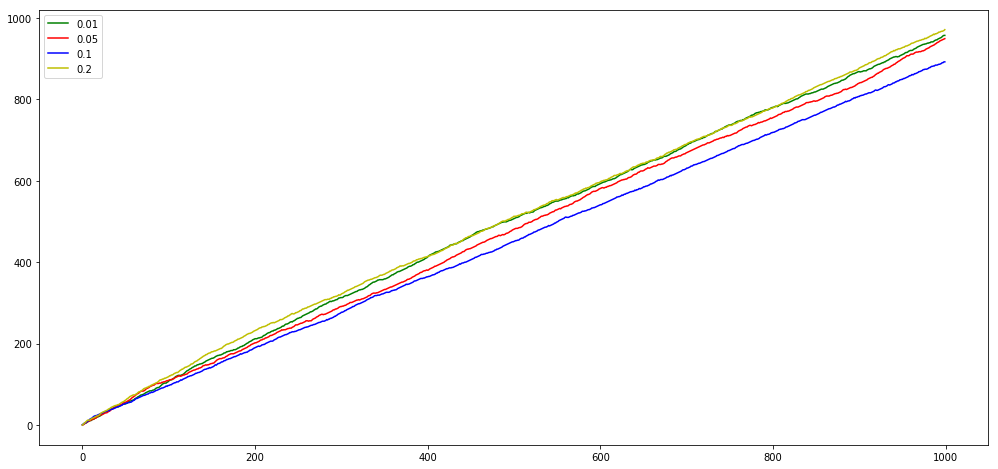

In [322]:
# Part 2 code, output your plot
import matplotlib.pyplot as plt
eps_list = [0.01, 0.05, 0.1, 0.2]
f,ax = plt.subplots(figsize = (17,8))

data_1 = run_trajectory_2(SimpleBandit(), [Epsilon_Greedy_Policy(9,eps_list[0])], 1000)
data_2 = run_trajectory_2(SimpleBandit(), [Epsilon_Greedy_Policy(9,eps_list[1])], 1000)
data_3 = run_trajectory_2(SimpleBandit(), [Epsilon_Greedy_Policy(9,eps_list[2])], 1000)
data_4 = run_trajectory_2(SimpleBandit(), [Epsilon_Greedy_Policy(9,eps_list[3])], 1000)
plt.plot(range(1000),data_1,'g-',label='0.01')
plt.plot(range(1000),data_2,'r-',label='0.05')
plt.plot(range(1000),data_3,'b-',label='0.1')
plt.plot(range(1000),data_4,'y-',label='0.2')
plt.legend()


### Findings and conclusion for part 2

In [ ]:
# Part 3 code, output your plot

### Findings and conclusion for part 3

In [ ]:
# Part 4 code, output your plot

### Findings and conclusion for part 4